In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.data import Data


# Concatenating all the data

In [3]:

# loading processed data
kaggle = pd.read_csv('data/processed/kaggle_transaction_dataset_centrality.csv')
kaggle


,address,flag,avgTimeBetweenSentTnx,avgTimeBetweenRecTnx,lifetime,sentTransactions,receivedTransactions,createdContracts,numUniqRecAddress,numUniqSentAddress,...,maxValSent,avgValSent,totalTransactions,totalEtherSent,totalEtherReceived,totalEtherSentContracts,totalEtherBalance,degree_centrality,betweeness_centrality,eigenvector_centrality
0,0xd0cc2b24980cbcca47ef755da88b220a82291407,1,5.807655e+04,7.148260e+07,46.00,66,21,0,17,47,...,183.0,5.559412,87,366.92119,367.213130,0.0,0.291940,0.000690,0.000035,5.955279e-04
1,0x4cdc1cba0aeb5539f2e0ba158281e67e0e54a9b1,1,0.000000e+00,7.529115e+08,35.00,0,2,0,2,0,...,0.0,0.000000,2,0.00000,0.013541,0.0,0.013541,0.000000,0.000000,7.626269e-22
2,0x00e01a648ff41346cdeb873182383333d2184dd1,1,1.710279e+06,6.820612e+07,299.00,15,22,0,21,13,...,25.0,13.330000,37,199.95000,200.216494,0.0,0.266494,0.000099,0.000002,5.036766e-05
3,0x858457daa7e087ad74cdeeceab8419079bc2ca03,1,1.576106e+04,1.352571e+07,36.00,109,111,0,104,54,...,680.0,14.959358,220,1630.57000,1630.577419,0.0,0.007419,0.000788,0.000056,6.104170e-04
4,0x240e125c20a4cc84bd6e7f8d1fd07aff4c06d43d,1,0.000000e+00,3.751409e+08,82.00,1,4,0,4,1,...,1.9,1.900000,5,1.90000,1.902199,0.0,0.002199,0.000000,0.000000,1.065087e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20297,0xfc930bc7aa32b14a87f49a4e120ff54f8f0a5e05,1,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0,...,0.0,0.000000,0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,-3.761354e-20
20298,0xfea28ca175a80f5a348016583961f63be8605f80,1,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0,...,0.0,0.000000,0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,-5.079336e-19
20299,0xff0e20e3a7575d823302bbb27e233c23f2c3070b,1,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0,...,0.0,0.000000,0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,1.983143e-20
20300,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0,...,0.0,0.000000,0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,2.919528e-19


In [4]:
dfs = []

for i in range(20):  
    file_path = f'../bt4012-group13/data/queried/transactions_{i}.csv'
    dfs.append(pd.read_csv(file_path))


merged_df = pd.concat(dfs)

# Display the shape and first few rows of the merged dataframe
merged_df.shape, merged_df.head()

/var/folders/03/rh1df1yd5y7bb1shd2_734pw0000gn/T/ipykernel_41673/2361987607.py:5: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(file_path))


((5238249, 7),
    flag                                address from  \
 0     1  0xc6c198c7e472de4313f2ae9c9b02185dd8d91262   
 1     1  0x028d61f42f1ca1ad6887f3311a0b1789ef6dadbb   
 2     1  0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98   
 3     1  0x2c2b7579e86363ccd46d0942f7fe274ccdbae351   
 4     1  0xabf1bbefc50800427ac69fa2e62ceac9b3b11d5b   
 
                                    address to   timestamp  \
 0  0x000000000532b45f47779fce440748893b257865  1594562749   
 1  0x000000000532b45f47779fce440748893b257865  1594563733   
 2  0x000000000532b45f47779fce440748893b257865  1594563793   
 3  0x000000000532b45f47779fce440748893b257865  1594563893   
 4  0x000000000532b45f47779fce440748893b257865  1594564904   
 
                  amount  gasUsed contractInteracted  
 0     10000000000000000    21000                NaN  
 1  10000000000000000000    21000                NaN  
 2   5000000000000000000    21000                NaN  
 3   5000000000000000000    21000                NaN 

In [5]:
merged_df = merged_df.sort_values(by='address from', ascending=False)
merged_df = merged_df.drop(['contractInteracted'], axis=1)

In [6]:
merged_df

,flag,address from,address to,timestamp,amount,gasUsed
230466,0,GENESIS,0x3c286cfb30146e5fd790c2c8541552578de334d8,1438269973,10203000000000000000000,0
327576,0,GENESIS,0x0fee81ac331efd8f81161c57382bb4507bb9ebec,1438269973,400030000000000000000,0
232479,0,0xffffffbf3bf3b043a7457e78b4a5313a58dc5d14,0x066798d9ef0833ccc719076dab77199ecbd178b0,1612867256,0,44407
192563,0,0xffffffbf3bf3b043a7457e78b4a5313a58dc5d14,0x0e192d382a36de7011f795acc4391cd302003606,1617585820,0,47142
22641,0,0xfffffd059e97c2bfc822569e13f636c3d176db41,0x2217e5921b7edfb4bb193a6228459974010d2198,1644941122,0,46361
...,...,...,...,...,...,...
250694,0,0x00000000000124d994209fbb955e0217b5c2eca1,0x25b24b3c47918b7962b3e49c4f468367f73cc0e0,1672398587,0,30627
251175,0,0x00000000000124d994209fbb955e0217b5c2eca1,0x25b24b3c47918b7962b3e49c4f468367f73cc0e0,1680910775,0,47727
250677,0,0x00000000000124d994209fbb955e0217b5c2eca1,0x25b24b3c47918b7962b3e49c4f468367f73cc0e0,1672350827,0,47751
250635,0,0x00000000000124d994209fbb955e0217b5c2eca1,0x25b24b3c47918b7962b3e49c4f468367f73cc0e0,1671697943,0,47216


In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
merged_df['address_from_encoded'] = label_encoder.fit_transform(merged_df['address from'])
merged_df['address_to_encoded'] = label_encoder.fit_transform(merged_df['address to'])
merged_df.drop(['address from', 'address to'], axis=1, inplace=True)
merged_df['amount'] = merged_df['amount'].astype(float)
merged_df

,flag,timestamp,amount,gasUsed,address_from_encoded,address_to_encoded
230466,0,1438269973,1.020300e+22,0,884862,91552
327576,0,1438269973,4.000300e+20,0,884862,25905
232479,0,1612867256,0.000000e+00,44407,884861,11319
192563,0,1617585820,0.000000e+00,47142,884861,23216
22641,0,1644941122,0.000000e+00,46361,884860,52901
...,...,...,...,...,...,...
250694,0,1672398587,0.000000e+00,30627,0,58216
251175,0,1680910775,0.000000e+00,47727,0,58216
250677,0,1672350827,0.000000e+00,47751,0,58216
250635,0,1671697943,0.000000e+00,47216,0,58216


In [16]:
X = merged_df.drop(['flag'], axis=1)
y = merged_df['flag']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3666774, 5), (1571475, 5), (3666774,), (1571475,))

In [24]:
# Define the model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define the XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic', random_state=1)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(classification_report(y_test, y_pred))


Accuracy: 0.9906062775417999
F1 score: 0.928330064280582
Precision: 0.9814096247023076
Recall: 0.8806975201739194
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1462919
           1       0.98      0.88      0.93    108556

    accuracy                           0.99   1571475
   macro avg       0.99      0.94      0.96   1571475
weighted avg       0.99      0.99      0.99   1571475



ROC AUC score: 0.9963359665509883


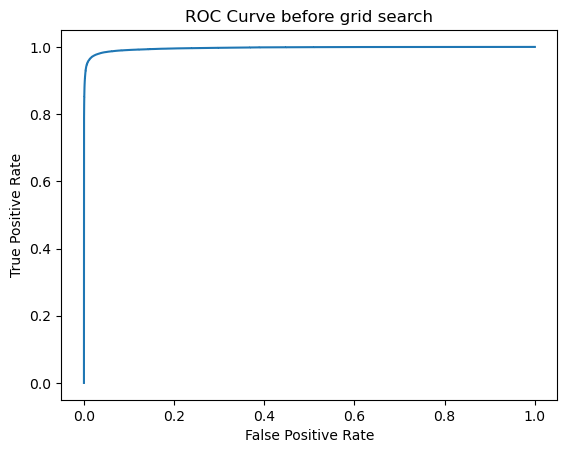

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve before grid search')

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC score: {roc_auc}")


In [26]:
# training xgboost with grid search, finding best parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}
# Define the XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic', random_state=1)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time= 7.8min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time= 7.9min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time= 7.9min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time= 7.9min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time= 7.9min


KeyboardInterrupt: 

In [ ]:
# Define the XGBoost model with the best parameters
xgb_model_tuned = XGBClassifier(objective='binary:logistic', random_state=1)
xgb_model_tuned.set_params(**grid_search.best_params_)

# Fit the model to the training data
xgb_model_tuned.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model_tuned.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(classification_report(y_test, y_pred))